# " Keep it Simple Stupid!"
# " Don't Repeat Yourself!"

# Writing a good function:
  
       -Sensibly named
      -Has a single responsibility
      -Includes a docstring
      -Returns a value
      -Is not longer than 50 lines
      -Is idempotent and, if possible , pure
  

In [23]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as Makecopy

from ipywidgets import IntProgress
from IPython.display import display

%matplotlib nbagg
%matplotlib inline
np.random.seed(1)
plt.style.use('ggplot')

In [24]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [25]:
######################## Read in the Data ###########################
Data = pd.read_csv('example_cubic_data.txt',delimiter=' ',names=['x','y','err'])
x_values = Data.x
y_values = Data.y
error_values = Data.err

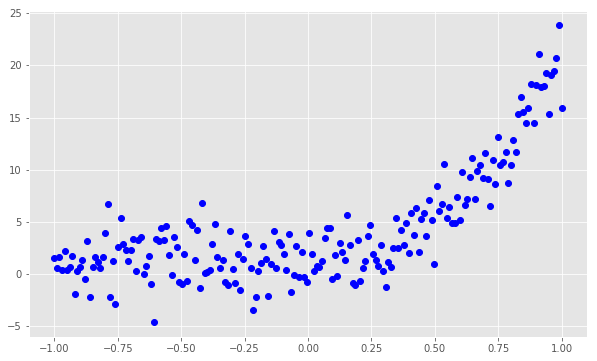

In [26]:
########################## Visualize the Data #####################
plt.figure(figsize=(10,6))
plt.plot(x_values,y_values,'o',color='blue')

In [27]:
def Model_function(params,x):
    '''Return the model value given a,b,c,d and x paramters'''
    
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    model_value =  a*x**3 + b*x**2 + c*x + d
    return model_value

def Log_Likelihood(data=None,sigma=None,model=None):
    
    '''Return the Log-Likelihood.
    lnLikelihood = sum(f(data|model,sigma^2))
                =-(n/2)*ln(2*pi) - (n/2)*ln(sigma^2) - (1/2*sigma^2)*sum((data-model)^2)    
    Keyword arguments:
    sigma -- noise level
    model    -- Model
    data     -- The data'''
    #Unit test for shape of data amd model
    assert data.shape == model.shape
    
    
    #Term1 = -0.5*np.log(2*np.pi*(sigma**2))
    Term2 = -0.5*(1/sigma**2)*(data-model)**2
    
    Log_Like = sum( Term2)
    
    return Log_Like

def prior_transform(u = None):
    '''Return the transformed prior space,array.'''
    
    a = 20.0*u[0]
    b = 20.0*u[1]
    c = 2.0*u[2]
    d = 2.0*u[3]
    
    return np.array([a,b,c,d])


def log_plus(x,y):
    '''Return the addition of x + y in log-space'''
    
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [52]:
# Number of live points
num_of_live_points = 500 

#Number of dimensions
ndim = 4

#Save objects
points = np.zeros((num_of_live_points,ndim))

#log_likelihood of live objects
log_like_of_live_points = np.zeros((num_of_live_points))


#Generate Live objects
for i in range(num_of_live_points):
    points[i,:] = prior_transform(u=np.random.uniform(0,1.0,size=ndim))
    model = Model_function(params=points[i,:],x=x_values)
    log_like_of_live_points[i] = Log_Likelihood(data=y_values,sigma=error_values,model=model)


In [53]:
nest = 5000
keep = np.zeros((nest,ndim))  #store bad points
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0


In [54]:
# Defined intervals for each parameters
Flat_interval = [(0,20),(0,20),(0,2),(0,2)]
mcmc_steps = 100
Acceptance = np.empty((nest))

In [55]:
#Progress bar report
progressor = IntProgress(
    value=0,
    min=0,
    max=nest,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor)
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / num_of_live_points))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(log_like_of_live_points)
    
    #Save worst opbject
    keep[i,:] = points[worst,:]
    logl_sample.append(log_like_of_live_points[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + log_like_of_live_points[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = log_plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*log_like_of_live_points[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/num_of_live_points
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(points))
        if (copy != worst):break
            
    points[worst,:] = Makecopy.deepcopy(points[copy,:])
    log_Likelihood_old =  log_like_of_live_points[copy]
    
    theta = points[copy,:]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (ndim,)
    
   # initialize mcmc params
    
    scale = 1.0
    accept = 0
    reject = 0
    for mcmci in range(mcmc_steps):  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        propose_step = np.random.normal(0,scale=scale,size=ndim)
        new_point = theta + propose_step
        
        
        add = 0
        for j in range(len(theta)):
                if Flat_interval[j][0] <= new_point[j] <= Flat_interval[j][1]:
                    add += 1
                else:
                    pass

        if add == len(theta):
            Prior = 1
        else:
            Prior = 0
        
        #Calculate Log_likelihood of new point
        model = Model_function(params=new_point,x=x_values)
        
        #Ignore divde by zero runtimewarining
        np.seterr(divide='ignore')
        log_Likelihood_new = Log_Likelihood(data=y_values,sigma=error_values,model=model) + np.log(Prior)
       
    
        #Acceptance ratio alpha
        alpha = np.exp(log_Likelihood_new-log_Likelihood_old)
        
        
        if alpha>=1:
            points[worst,:] = new_point  #Replace worst point with new point
            log_like_of_live_points[worst] = log_Likelihood_new   #Replace the worst likelihood with new one  
            accept += 1
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                points[worst,:] = new_point 
                log_like_of_live_points[worst] = log_Likelihood_new
                accept += 1
                
            else:
                theta = theta
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    Acceptance_Ratio = accept/(accept+reject)
    Acceptance[i] =  Acceptance_Ratio
    
    progressor.value += 1
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        
if progressor.value == progressor.max:
    progressor.description = "Done!"

Z = logZ
Z_err = np.sqrt((H)/num_of_live_points)
H = H        #np.exp(H)/np.log(2.)
#print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

IntProgress(value=0, bar_style='success', description='Loading:', max=5000)

Evidence Z = -104.74872132815916 +-0.09847189793603067 : Information H = 4.848357341562021 


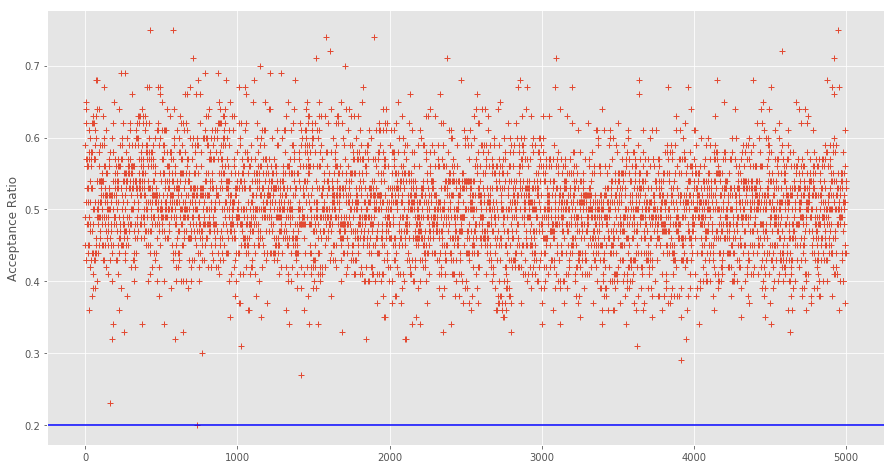

In [56]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,len(Acceptance)),Acceptance,'+')
plt.ylabel('Acceptance Ratio')
plt.axhline(0.2,c='blue')

In [57]:

#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))

print('Effective Sample Size : {}'.format(effective_sample_size))
#Progress bar
progressor_samples = IntProgress(
    value=0,
    min=0,
    max=effective_sample_size,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor_samples)


# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)

    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        
        S += 1
        progressor_samples.value += 1
    if S >= effective_sample_size:
        break

Effective Sample Size : 2128


IntProgress(value=0, bar_style='success', description='Loading:', max=2128)

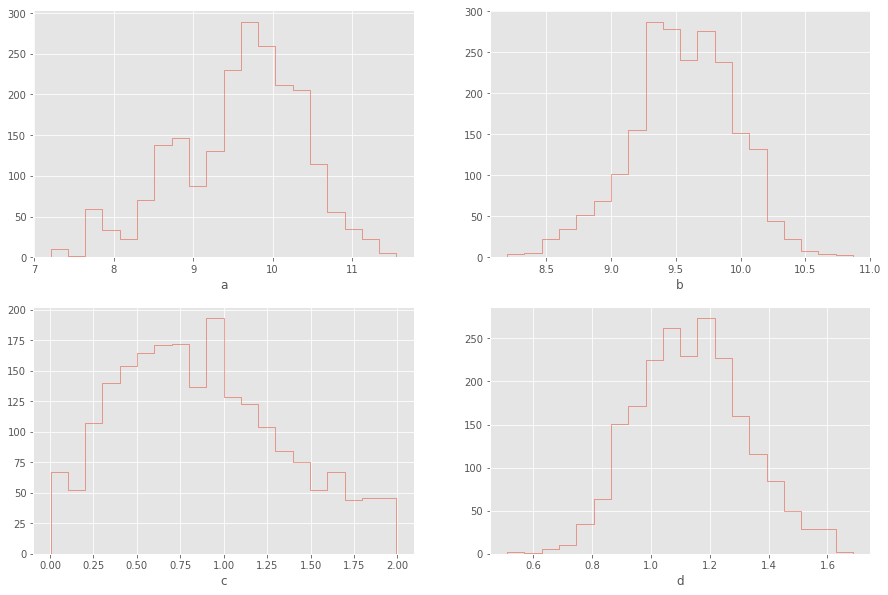

In [58]:
plt.figure(figsize=(15,10))

labels = ['a','b','c','d']
for i in range(ndim):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i],histtype="step",bins=20)
    plt.xlabel(labels[i])
    

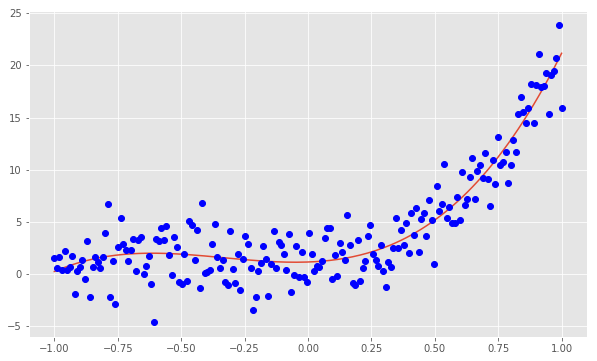

In [59]:
a,b,c,d = np.mean(sample[:,0]),np.mean(sample[:,1]),np.mean(sample[:,2]),np.mean(sample[:,3])
y_model = a*x_values**3 + b*x_values**2 + c*x_values + d

plt.figure(figsize=(10,6))
plt.plot(x_values,y_model)
plt.plot(x_values,y_values,'o',color='blue')

In [60]:
a,b,c,d

(9.595396922782747, 9.557238123156079, 0.8732631601040218, 1.1382335356717792)

## Stats from pymultinest